,K,D,OB,OS,Final,Trades,Win Rate (%),Momentum %,Swing %
0,21,5,70,10,1049825.25,1553,42.9,30.3,69.7
1,14,7,70,10,1045827.75,1297,43.3,30.6,69.4
2,21,5,80,10,1044535.25,1240,43.2,31.9,68.1
3,14,7,80,10,1038662.50,856,43.7,32.6,67.4
4,21,7,80,10,1036927.25,980,43.0,32.0,68.0
5,21,7,70,10,1031704.25,1329,42.2,30.6,69.4
6,21,5,70,20,1027985.25,2011,41.2,30.0,70.0
7,14,7,90,10,1023442.25,288,45.5,33.7,66.3
8,21,5,80,20,1021640.75,1752,41.4,31.2,68.8
9,10,7,70,10,1020419.25,1207,41.8,30.6,69.4


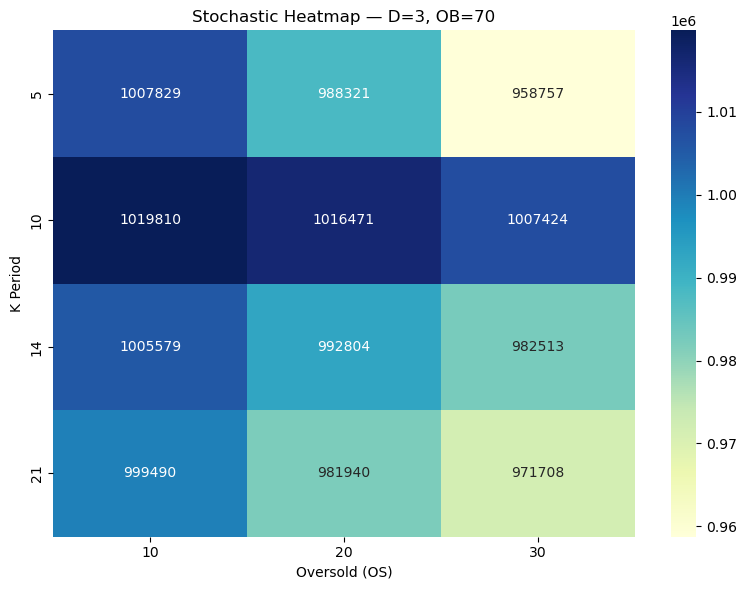

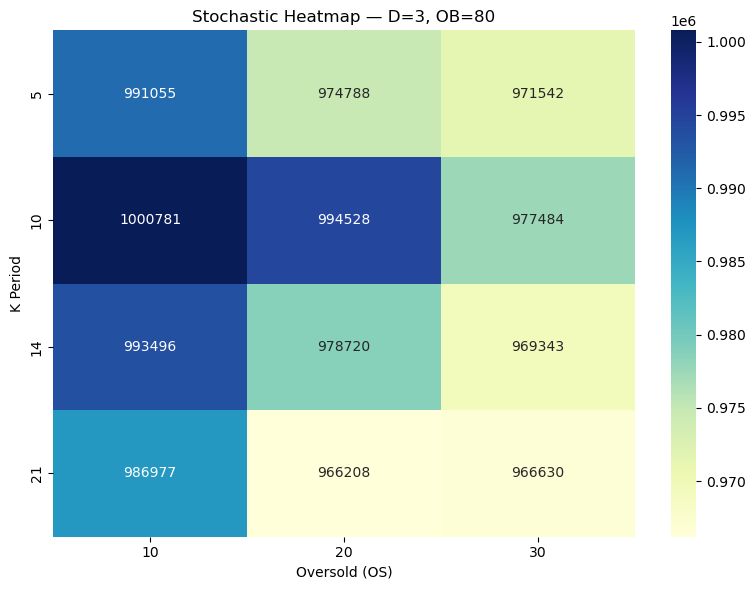

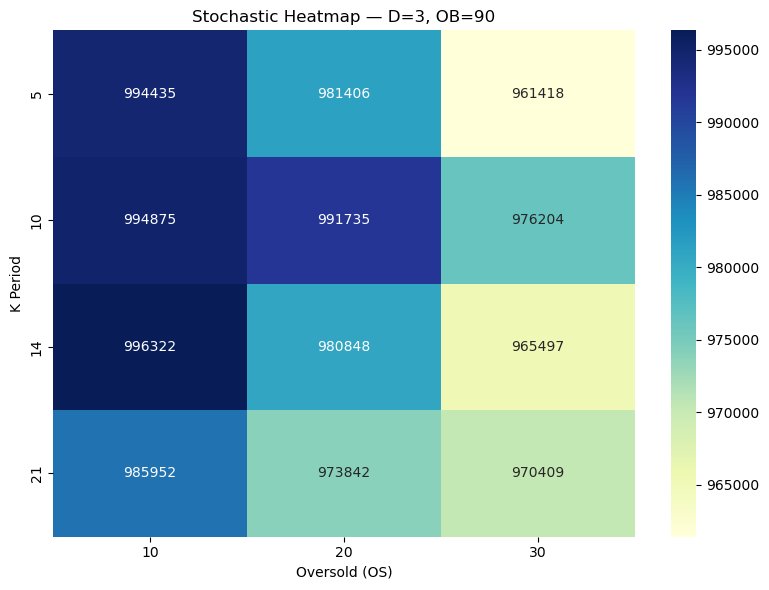

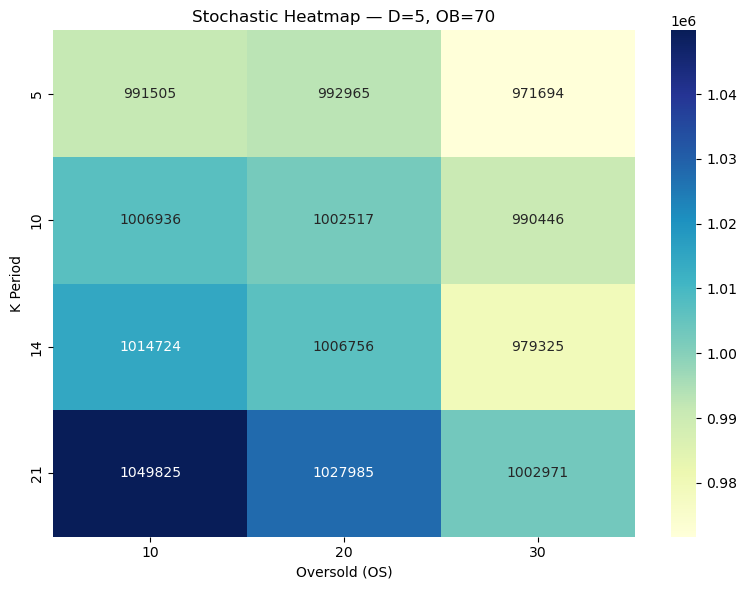

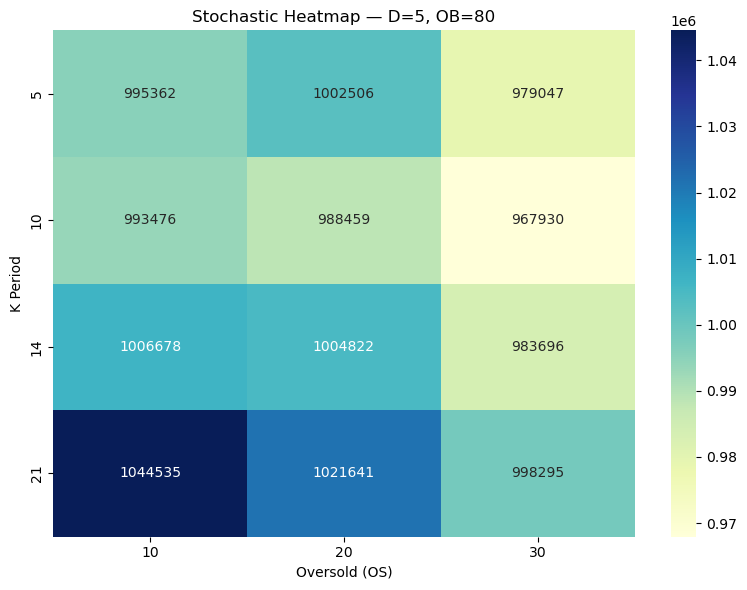

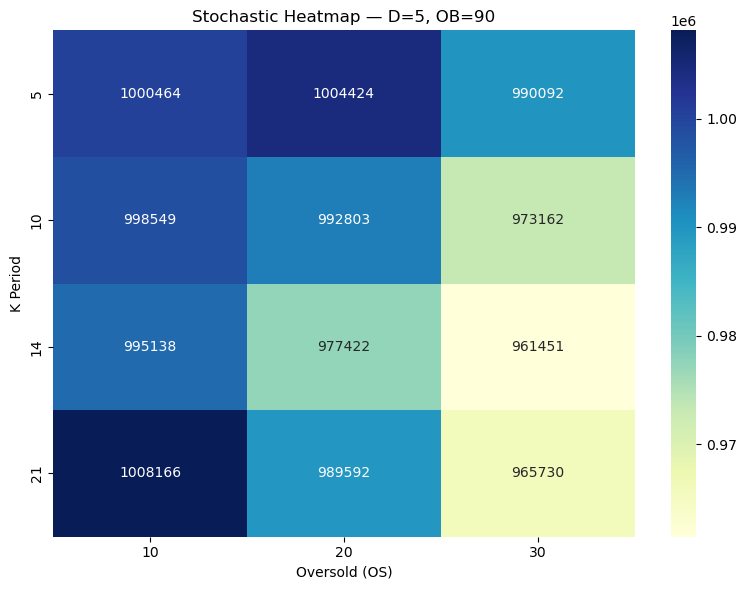

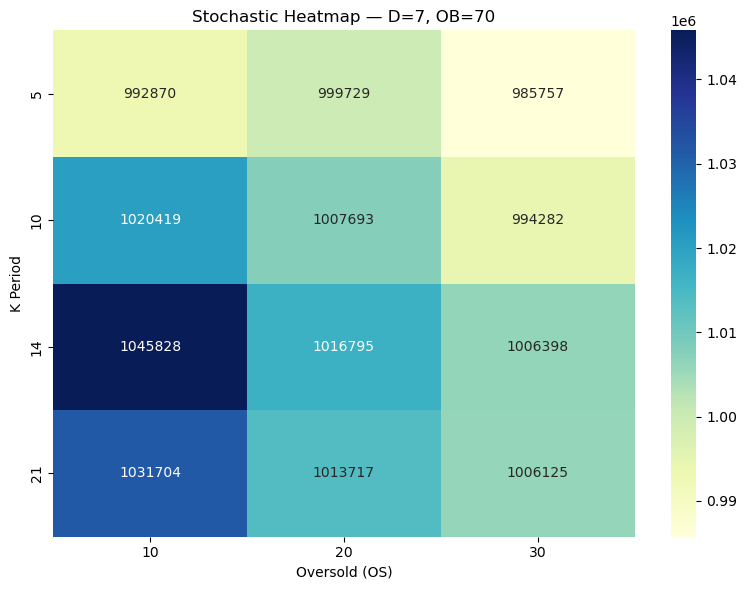

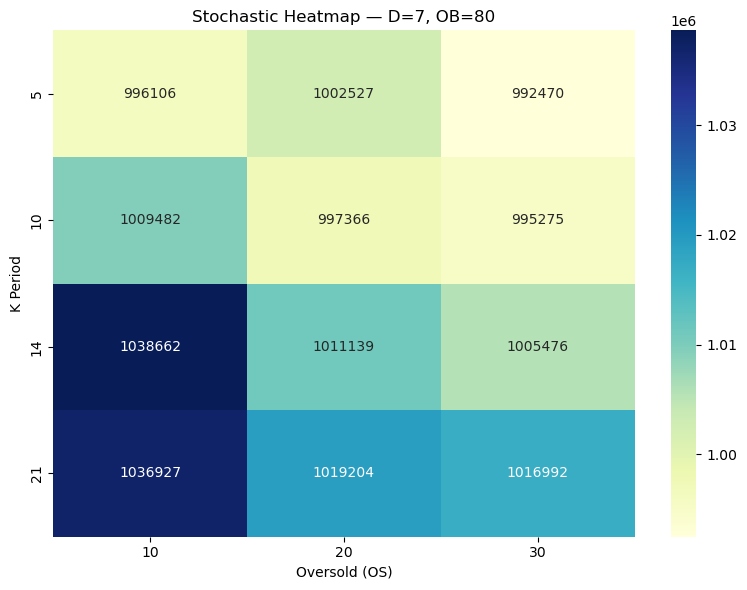

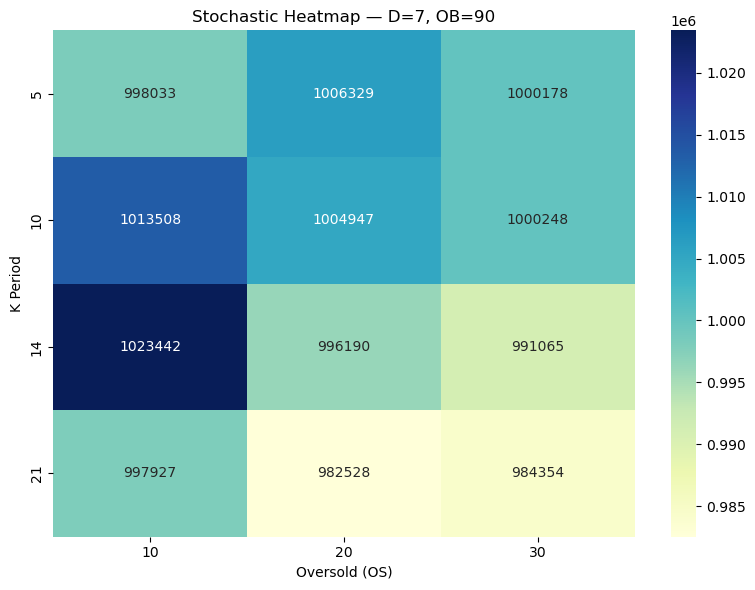

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── LOAD AND PREP DATA ─────────────────────────────────────────
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# ─── Stochastic Parameter Grid ────────────────────────────────────────
k_periods = [5, 10, 14, 21]
d_periods = [3, 5, 7]
overbought_list = [70, 80, 90]
oversold_list = [10, 20, 30]

# ─── Constants ────────────────────────────────────────────────────────
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY = 500

# ─── Prepare Data ─────────────────────────────────────────────────────
df_stoch = df.copy()
returns = df_stoch['close'].pct_change()
df_stoch['VOL_S'] = returns.rolling(VOL_WIN).std()
df_stoch['VOL_L'] = returns.rolling(VOL_MED_WIN).std()
df_stoch['VOL_RATIO'] = df_stoch['VOL_S'] / df_stoch['VOL_L']

tr1 = df_stoch['high'] - df_stoch['low']
tr2 = (df_stoch['high'] - df_stoch['close'].shift()).abs()
tr3 = (df_stoch['low'] - df_stoch['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df_stoch['ATR'] = tr.rolling(14).mean()

results = []

# ─── Optimization Loop ────────────────────────────────────────────────
for k in k_periods:
    lowest_low = df_stoch['low'].rolling(k).min()
    highest_high = df_stoch['high'].rolling(k).max()
    df_stoch['%K'] = 100 * (df_stoch['close'] - lowest_low) / (highest_high - lowest_low)

    for d in d_periods:
        df_stoch['%D'] = df_stoch['%K'].rolling(d).mean()

        for ob in overbought_list:
            for os in oversold_list:
                df_stoch['Signal'] = 0
                long_entry = (df_stoch['%K'].shift(1) < df_stoch['%D'].shift(1)) & \
                             (df_stoch['%K'] > df_stoch['%D']) & \
                             (df_stoch['%K'] < os)
                short_entry = (df_stoch['%K'].shift(1) > df_stoch['%D'].shift(1)) & \
                              (df_stoch['%K'] < df_stoch['%D']) & \
                              (df_stoch['%K'] > ob)
                df_stoch.loc[long_entry, 'Signal'] = 1
                df_stoch.loc[short_entry, 'Signal'] = -1

                cash, pos = CASH0, 0
                stop = target = entry_price = None
                equity = []
                num_trades = 0
                wins = 0
                momentum_trades = 0
                swing_trades = 0

                for _, row in df_stoch.iterrows():
                    price = row['close']
                    atr = row['ATR']
                    sig = row['Signal']
                    vol_ratio = row['VOL_RATIO']

                    # Exit logic
                    if pos > 0 and (price >= target or price <= stop):
                        cash += pos * price
                        pnl = price - entry_price
                        if pnl > 0: wins += 1
                        pos = 0
                    elif pos < 0 and (price <= target or price >= stop):
                        cash -= -pos * price
                        pnl = entry_price - price
                        if pnl > 0: wins += 1
                        pos = 0

                    # Entry logic
                    if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
                        if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                            qty = min(int((cash * RISK_PCT) / price), MAX_QTY)
                            entry_price = price

                            if sig == 1:
                                cash -= qty * price
                                pos = qty
                                stop = price - 2.0 * atr
                                target = price + 3.0 * atr
                                num_trades += 1
                                if vol_ratio > THR_HIGH:
                                    momentum_trades += 1
                                elif vol_ratio < THR_LOW:
                                    swing_trades += 1
                            elif sig == -1:
                                cash += qty * price
                                pos = -qty
                                stop = price + 2.0 * atr
                                target = price - 3.0 * atr
                                num_trades += 1
                                if vol_ratio > THR_HIGH:
                                    momentum_trades += 1
                                elif vol_ratio < THR_LOW:
                                    swing_trades += 1

                    equity.append(cash if pos == 0 else cash + pos * price)

                if equity:
                    results.append({
                        'K': k,
                        'D': d,
                        'OB': ob,
                        'OS': os,
                        'Final': equity[-1],
                        'Trades': num_trades,
                        'Win Rate (%)': round(wins / num_trades * 100, 1) if num_trades > 0 else 0,
                        'Momentum %': round(momentum_trades / num_trades * 100, 1) if num_trades > 0 else 0,
                        'Swing %': round(swing_trades / num_trades * 100, 1) if num_trades > 0 else 0
                    })

# ─── Results and Visuals ─────────────────────────────────────────────
df_stoch_res = pd.DataFrame(results)
summary = df_stoch_res.sort_values('Final', ascending=False).reset_index(drop=True)
display(summary.head(10))

# Optional export
# summary.to_csv("stochastic_summary.csv", index=False)

# Heatmaps
for fixed_d in sorted(df_stoch_res['D'].unique()):
    for fixed_ob in sorted(df_stoch_res['OB'].unique()):
        subset = df_stoch_res[(df_stoch_res['D'] == fixed_d) & (df_stoch_res['OB'] == fixed_ob)]
        pivot = subset.pivot(index='K', columns='OS', values='Final')
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
        plt.title(f"Stochastic Heatmap — D={fixed_d}, OB={fixed_ob}")
        plt.xlabel('Oversold (OS)')
        plt.ylabel('K Period')
        plt.tight_layout()
        plt.show()


In [3]:
print(f"Number of observations in dataset: {len(df)}")


Number of observations in dataset: 69055


In [6]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Final chosen parameters
K, D, OB, OS = 14, 7, 70, 10
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY = 500

# Indicators
returns = df['close'].pct_change()
df['VOL_S'] = returns.rolling(VOL_WIN).std()
df['VOL_L'] = returns.rolling(VOL_MED_WIN).std()
df['VOL_RATIO'] = df['VOL_S'] / df['VOL_L']
tr1 = df['high'] - df['low']
tr2 = (df['high'] - df['close'].shift()).abs()
tr3 = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df['ATR'] = tr.rolling(14).mean()
df['%K'] = 100 * (df['close'] - df['low'].rolling(K).min()) / (df['high'].rolling(K).max() - df['low'].rolling(K).min())
df['%D'] = df['%K'].rolling(D).mean()

# Generate signals
df['Signal'] = 0
df.loc[(df['%K'].shift(1) < df['%D'].shift(1)) & (df['%K'] > df['%D']) & (df['%K'] < OS), 'Signal'] = 1
df.loc[(df['%K'].shift(1) > df['%D'].shift(1)) & (df['%K'] < df['%D']) & (df['%K'] > OB), 'Signal'] = -1

# Periods
periods = {
    "03 Feb – 18 Feb": ("2025-02-03", "2025-02-18"),
    "31 Mar – 15 Apr": ("2025-03-31", "2025-04-15"),
    "Full period": (df.index.min(), df.index.max())
}

# Strategy Evaluation
results = []
for name, (start, end) in periods.items():
    df_p = df.loc[start:end].copy()
    cash, pos = CASH0, 0
    stop = target = entry_price = None
    trades, wins, swing, momentum = 0, 0, 0, 0
    equity = []

    for i in range(1, len(df_p)):
        price = df_p['close'].iloc[i]
        atr = df_p['ATR'].iloc[i]
        sig = df_p['Signal'].iloc[i]
        vol_ratio = df_p['VOL_RATIO'].iloc[i]

        # Exit
        if pos > 0 and (price >= target or price <= stop):
            pnl = price - entry_price
            wins += pnl > 0
            cash += pos * price
            pos = 0
        elif pos < 0 and (price <= target or price >= stop):
            pnl = entry_price - price
            wins += pnl > 0
            cash -= -pos * price
            pos = 0

        # Entry
        if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
            if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                qty = min(int((cash * RISK_PCT) / price), MAX_QTY)
                entry_price = price
                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - 2.0 * atr
                    target = price + 3.0 * atr
                elif sig == -1:
                    cash += qty * price
                    pos = -qty
                    stop = price + 2.0 * atr
                    target = price - 3.0 * atr
                trades += 1
                swing += vol_ratio < THR_LOW
                momentum += vol_ratio > THR_HIGH

        equity.append(cash if pos == 0 else cash + pos * price)

    close_prices = df_p['close']
    bh_equity = CASH0 * (close_prices.iloc[-1] / close_prices.iloc[0]) if not close_prices.empty else CASH0

    results.append({
        "Period": name,
        "Trades": trades,
        "Final (Stoch)": round(equity[-1] if equity else CASH0, 2),
        "Buy & Hold": round(bh_equity, 2),
        "Win Rate (%)": round((wins / trades * 100), 1) if trades > 0 else 0,
        "Swing %": round((swing / trades * 100), 1) if trades > 0 else 0,
        "Momentum %": round((momentum / trades * 100), 1) if trades > 0 else 0
    })

# Print results
summary_df = pd.DataFrame(results)
print(summary_df.to_string(index=False))


         Period  Trades  Final (Stoch)  Buy & Hold  Win Rate (%)  Swing %  Momentum %
03 Feb – 18 Feb     264      997433.75  1032037.29          36.7     75.0        25.0
31 Mar – 15 Apr     324     1024339.50   975487.56          45.1     69.4        30.6
    Full period    1297     1045827.75   915686.93          43.3     69.4        30.6


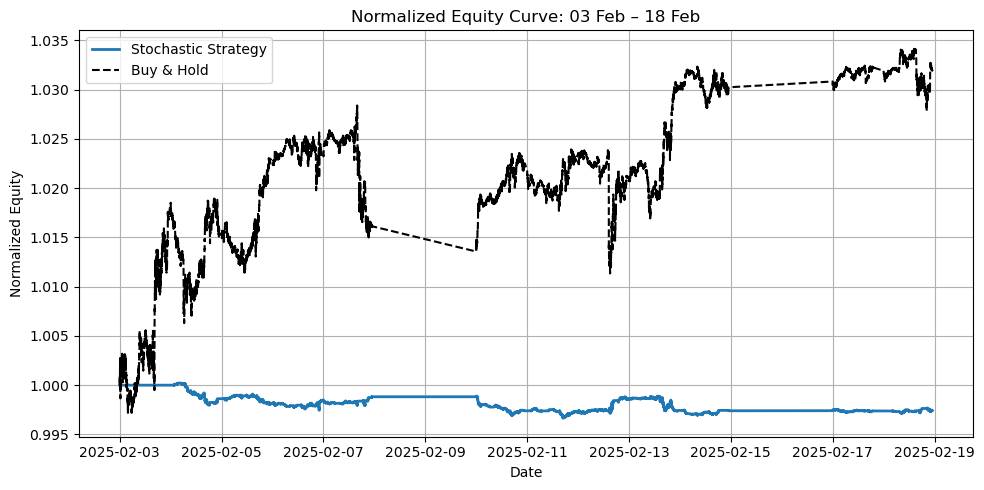

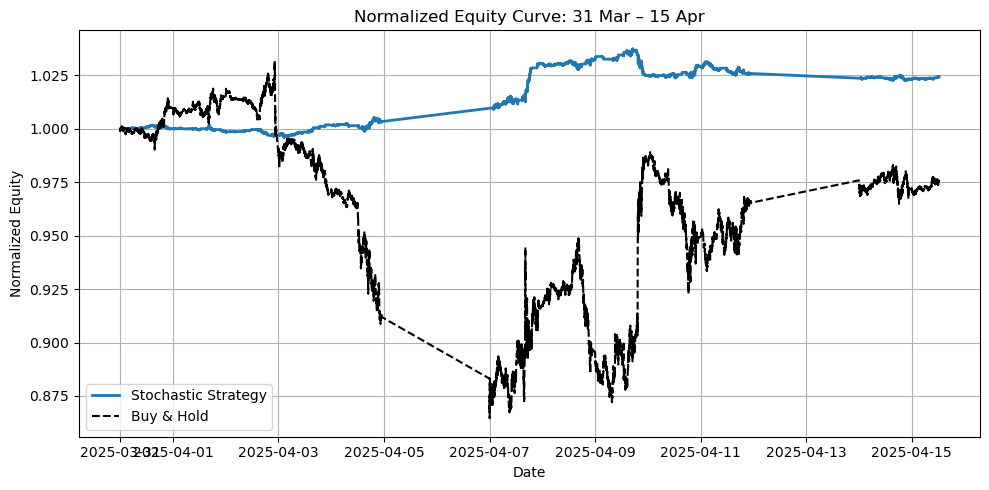

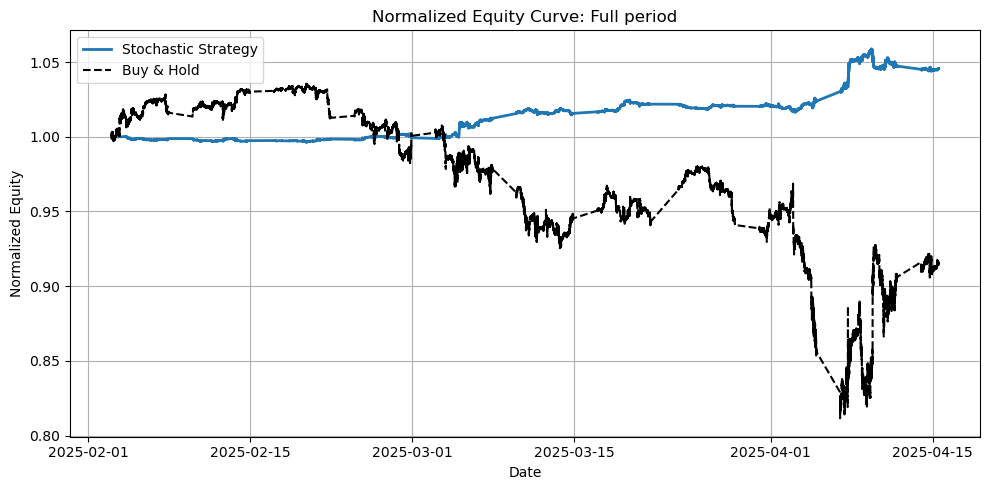

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("combined_all_three.csv", parse_dates=["timestamp"]).set_index("timestamp")

# Parameters
K, D, OB, OS = 14, 7, 70, 10
VOL_WIN, VOL_MED_WIN = 80, 1440
CASH0, RISK_PCT, MAX_QTY = 1_000_000, 0.20, 500

# Indicators
returns = df['close'].pct_change()
df['VOL_S'] = returns.rolling(VOL_WIN).std()
df['VOL_L'] = returns.rolling(VOL_MED_WIN).std()
df['VOL_RATIO'] = df['VOL_S'] / df['VOL_L']
tr1 = df['high'] - df['low']
tr2 = (df['high'] - df['close'].shift()).abs()
tr3 = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df['ATR'] = tr.rolling(14).mean()
df['%K'] = 100 * (df['close'] - df['low'].rolling(K).min()) / (df['high'].rolling(K).max() - df['low'].rolling(K).min())
df['%D'] = df['%K'].rolling(D).mean()

# Signals
df['Signal'] = 0
df.loc[(df['%K'].shift(1) < df['%D'].shift(1)) & (df['%K'] > df['%D']) & (df['%K'] < OS), 'Signal'] = 1
df.loc[(df['%K'].shift(1) > df['%D'].shift(1)) & (df['%K'] < df['%D']) & (df['%K'] > OB), 'Signal'] = -1

# Plotting function
def plot_stoch_equity(start, end, title):
    df_p = df.loc[start:end].copy()
    cash, pos = CASH0, 0
    stop = target = entry = None
    equity = []

    for i in range(len(df_p)):
        price = df_p["close"].iloc[i]
        atr = df_p["ATR"].iloc[i]
        sig = df_p["Signal"].iloc[i]
        vol_ratio = df_p["VOL_RATIO"].iloc[i]

        if pos > 0 and (price >= target or price <= stop):
            cash += pos * price
            pos = 0
        elif pos < 0 and (price <= target or price >= stop):
            cash -= -pos * price
            pos = 0

        if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
            if vol_ratio > 1.1 or vol_ratio < 0.9:
                qty = min(int((cash * RISK_PCT) / price), MAX_QTY)
                entry = price
                if sig == 1:
                    cash -= qty * price
                    pos = qty
                    stop = price - 2 * atr
                    target = price + 3 * atr
                elif sig == -1:
                    cash += qty * price
                    pos = -qty
                    stop = price + 2 * atr
                    target = price - 3 * atr

        equity.append(cash if pos == 0 else cash + pos * price)

    equity_series = pd.Series(equity, index=df_p.index) / CASH0
    bh_series = df_p["close"] / df_p["close"].iloc[0]

    plt.figure(figsize=(10, 5))
    plt.plot(equity_series, label="Stochastic Strategy", linewidth=2)
    plt.plot(bh_series, label="Buy & Hold", linestyle="--", color="black")
    plt.title(f"Normalized Equity Curve: {title}")
    plt.xlabel("Date")
    plt.ylabel("Normalized Equity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Display plots
plot_stoch_equity("2025-02-03", "2025-02-18", "03 Feb – 18 Feb")
plot_stoch_equity("2025-03-31", "2025-04-15", "31 Mar – 15 Apr")
plot_stoch_equity(df.index.min(), df.index.max(), "Full period")


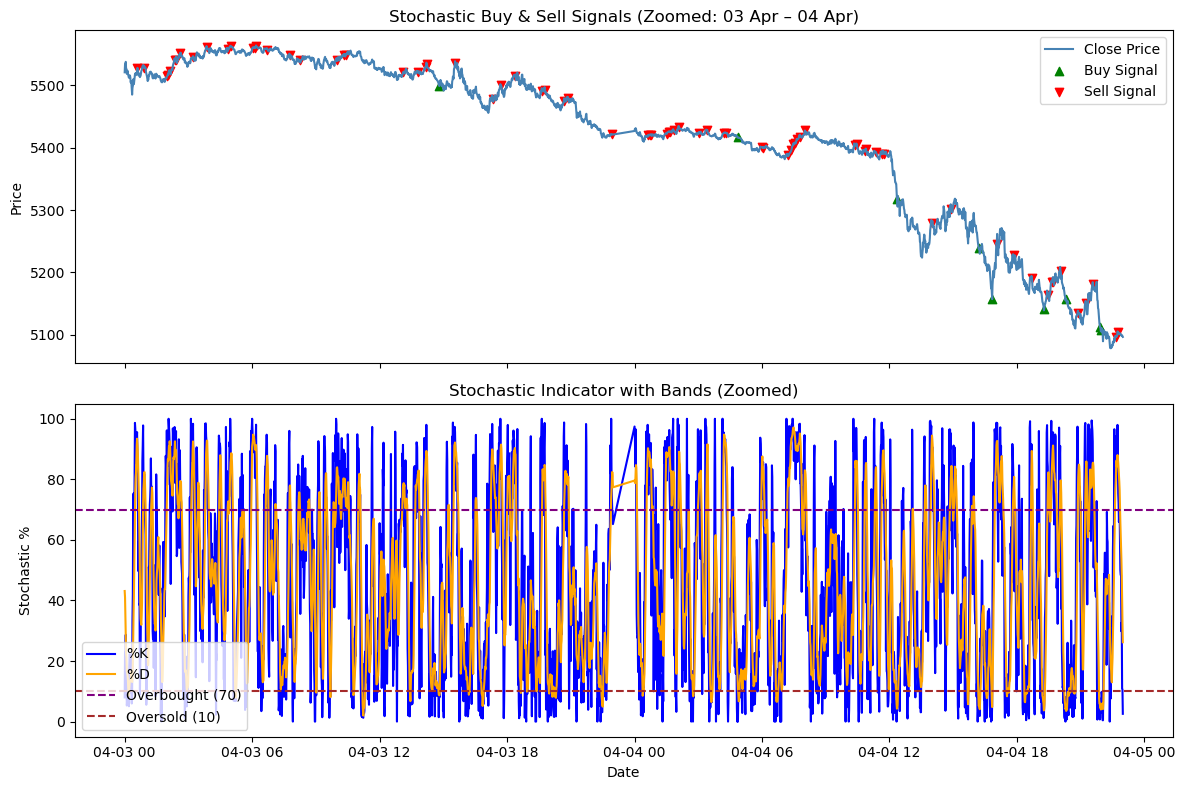

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# Final stochastic parameters
K, D, OB, OS = 14, 7, 70, 10

# Calculate %K and %D
df['Lowest Low'] = df['low'].rolling(K).min()
df['Highest High'] = df['high'].rolling(K).max()
df['%K'] = 100 * (df['close'] - df['Lowest Low']) / (df['Highest High'] - df['Lowest Low'])
df['%D'] = df['%K'].rolling(D).mean()

# Generate signals
df['Signal'] = 0
df.loc[(df['%K'].shift(1) < df['%D'].shift(1)) & (df['%K'] > df['%D']) & (df['%K'] < OS), 'Signal'] = 1
df.loc[(df['%K'].shift(1) > df['%D'].shift(1)) & (df['%K'] < df['%D']) & (df['%K'] > OB), 'Signal'] = -1

# Filter for single zoomed-in day
start, end = "2025-04-03", "2025-04-04"
df_zoom = df.loc[start:end].copy()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Price chart with signals
ax1.plot(df_zoom.index, df_zoom['close'], label='Close Price', color='steelblue')
ax1.scatter(df_zoom[df_zoom['Signal'] == 1].index, df_zoom[df_zoom['Signal'] == 1]['close'], label='Buy Signal', color='green', marker='^')
ax1.scatter(df_zoom[df_zoom['Signal'] == -1].index, df_zoom[df_zoom['Signal'] == -1]['close'], label='Sell Signal', color='red', marker='v')
ax1.set_title("Stochastic Buy & Sell Signals (Zoomed: 03 Apr – 04 Apr)")
ax1.set_ylabel("Price")
ax1.legend()

# %K and %D with thresholds
ax2.plot(df_zoom.index, df_zoom['%K'], label='%K', color='blue')
ax2.plot(df_zoom.index, df_zoom['%D'], label='%D', color='orange')
ax2.axhline(y=OB, color='purple', linestyle='--', label='Overbought (70)')
ax2.axhline(y=OS, color='brown', linestyle='--', label='Oversold (10)')
ax2.set_title("Stochastic Indicator with Bands (Zoomed)")
ax2.set_ylabel("Stochastic %")
ax2.set_xlabel("Date")
ax2.legend()

plt.tight_layout()
plt.show()


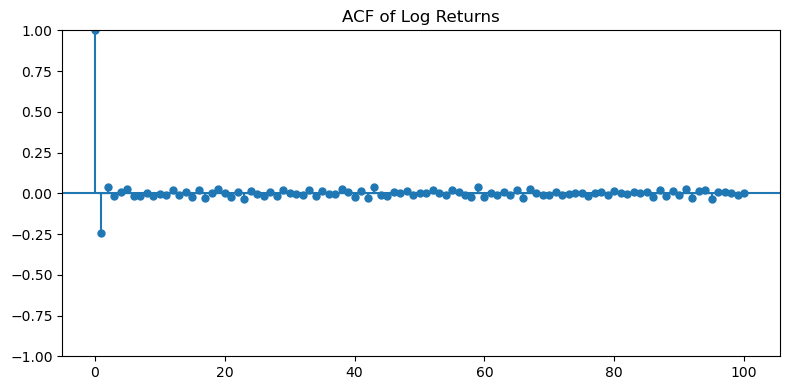

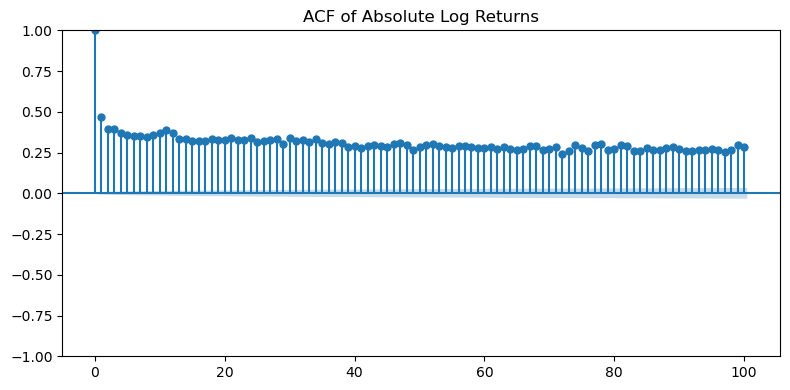

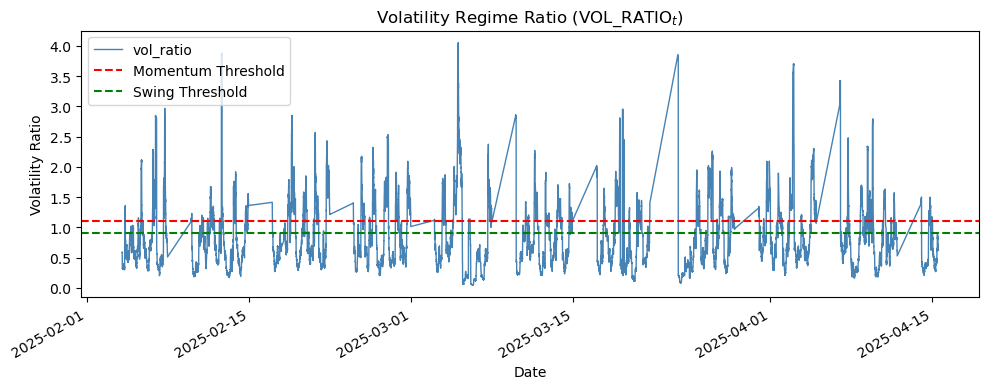

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Load your dataset
df = pd.read_csv("combined_all_three.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

# Compute 1-minute log returns
df["log_return"] = np.log(df["close"]).diff()
df["abs_return"] = df["log_return"].abs()

# Compute rolling volatilities
df["vol_short"] = df["close"].pct_change().rolling(80).std()
df["vol_long"] = df["close"].pct_change().rolling(1440).std()
df["vol_ratio"] = df["vol_short"] / df["vol_long"]

# Plot ACF of log returns
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(df["log_return"].dropna(), lags=100, ax=ax, title="ACF of Log Returns")
plt.tight_layout()
plt.show()

# Plot ACF of absolute returns
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(df["abs_return"].dropna(), lags=100, ax=ax, title="ACF of Absolute Log Returns")
plt.tight_layout()
plt.show()

# Plot volatility ratio
plt.figure(figsize=(10, 4))
df["vol_ratio"].plot(color="steelblue", linewidth=1)
plt.axhline(1.1, color="red", linestyle="--", label="Momentum Threshold")
plt.axhline(0.9, color="green", linestyle="--", label="Swing Threshold")
plt.title("Volatility Regime Ratio ($\\text{VOL\\_RATIO}_t$)")
plt.ylabel("Volatility Ratio")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()
